In [1]:
import os
import zipfile
import urllib.request

# Define the URL and output path
url = "https://archive.ics.uci.edu/static/public/121/eeg+database.zip"
output_path = "eeg_database.zip"

# Download the dataset
urllib.request.urlretrieve(url, output_path)
print("✅ Download complete!")

# Extract the ZIP file
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall("eeg_dataset")
    print("✅ Extraction complete!")

# List the extracted files
print("📁 Extracted files:")
for root, dirs, files in os.walk("eeg_dataset"):
    for file in files:
        print(os.path.join(root, file))

✅ Download complete!
✅ Extraction complete!
📁 Extracted files:
eeg_dataset/eeg.full.html
eeg_dataset/alcoholic.gif
eeg_dataset/control.gif
eeg_dataset/eeg.html
eeg_dataset/SMNI_CMI_TEST.tar.gz
eeg_dataset/eeg_full.tar
eeg_dataset/eeg.data.html
eeg_dataset/smni_eeg_data.tar.gz
eeg_dataset/SMNI_CMI_TRAIN.tar.gz
eeg_dataset/eeg_full/co2a0000438.tar.gz
eeg_dataset/eeg_full/co2c0000387.tar.gz
eeg_dataset/eeg_full/co2a0000375.tar.gz
eeg_dataset/eeg_full/co3a0000458.tar.gz
eeg_dataset/eeg_full/co2a0000416.tar.gz
eeg_dataset/eeg_full/co2a0000447.tar.gz
eeg_dataset/eeg_full/co2a0000385.tar.gz
eeg_dataset/eeg_full/co2c0000364.tar.gz
eeg_dataset/eeg_full/co2c0000382.tar.gz
eeg_dataset/eeg_full/co3a0000455.tar.gz
eeg_dataset/eeg_full/co2a0000386.tar.gz
eeg_dataset/eeg_full/co3a0000457.tar.gz
eeg_dataset/eeg_full/co2c0000348.tar.gz
eeg_dataset/eeg_full/co2a0000423.tar.gz
eeg_dataset/eeg_full/co2a0000379.tar.gz
eeg_dataset/eeg_full/co2a0000402.tar.gz
eeg_dataset/eeg_full/co2c0000344.tar.gz
eeg_datas


✅ Top 10 Active Electrodes: ['P4', 'C4', 'FC6', 'FP1', 'FC5', 'FZ', 'O2', 'PZ', 'T7', 'P7']

📌 Top 15 Features & Electrodes:
            feature  importance electrode
59           P4_std    0.068983        P4
48           C4_zcr    0.039601        C4
45   C3_theta_power    0.037307        C3
70   PZ_wavelet_std    0.035821        PZ
25   FC6_beta_power    0.034466       FC6
57           P3_std    0.032559        P3
21      F3_mobility    0.029582        F3
26  FC6_gamma_power    0.023755       FC6
15   FZ_theta_power    0.022107        FZ
81   O2_gamma_power    0.019213        O2
61   P4_theta_power    0.018627        P4
50   C4_theta_power    0.017886        C4
62   P4_alpha_power    0.017721        P4
71           P8_std    0.016743        P8
96           OZ_std    0.015336        OZ

=== FINAL TEST REPORT ===
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       300
           1       0.98      0.87      0.92       300

    accurac

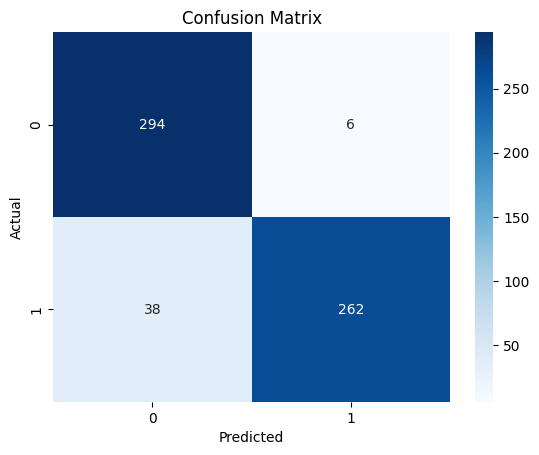

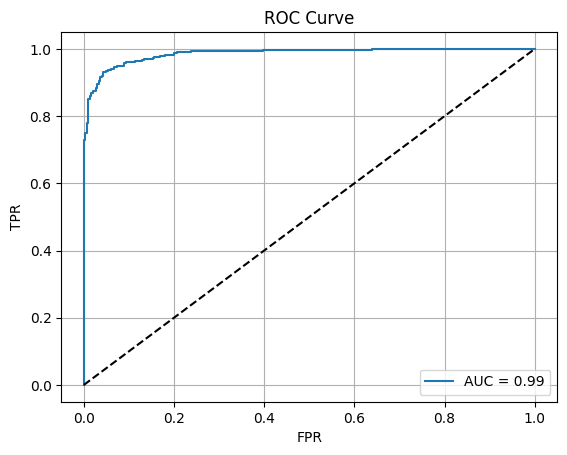

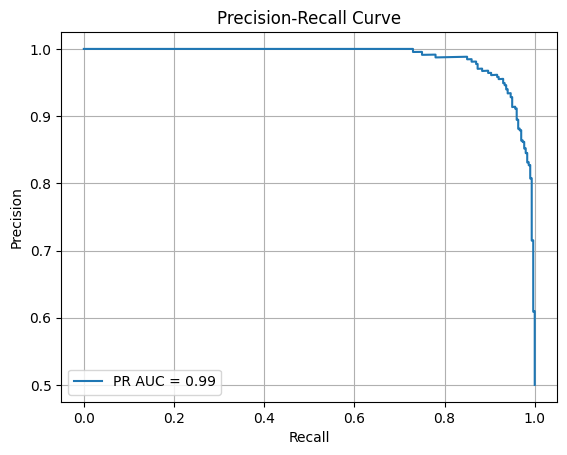

In [2]:
# === ADVANCED EEG CLASSIFICATION PIPELINE with Feature Importance and Active Electrode Analysis ===
import tarfile, gzip, numpy as np, pandas as pd
from collections import defaultdict
from io import BytesIO
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, roc_curve, auc,
    precision_recall_curve, f1_score, matthews_corrcoef, cohen_kappa_score
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, warnings
warnings.filterwarnings("ignore")

# === CONFIG ===
fs = 256
freq_bands = {
    'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)
}
known_channels = {
    'FP1','FP2','F7','F3','FZ','F4','F8','T7','C3','CZ','C4','T8','P7','P3','PZ','P4','P8',
    'O1','O2','AF3','AF4','FC5','FC6','CP5','CP6','PO3','PO4','OZ','FT7','FT8','TP7','TP8','PO7','PO8'
}

# === SIGNAL UTILITIES ===
def bandpass_filter(signal, lowcut=1.0, highcut=50.0, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

def bandpower(signal, band):
    fmin, fmax = band
    freqs, psd = welch(signal, fs)
    return np.mean(psd[(freqs >= fmin) & (freqs <= fmax)])

def zero_crossing_rate(signal):
    return ((np.diff(np.sign(signal)) != 0).sum()) / len(signal)

def hjorth_parameters(signal):
    first_deriv = np.diff(signal)
    second_deriv = np.diff(first_deriv)
    var_zero = np.var(signal)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility
    return activity, mobility, complexity

def wavelet_features(signal):
    coeffs, _ = pywt.cwt(signal, scales=np.arange(1, 32), wavelet='morl', sampling_period=1/fs)
    return np.mean(np.abs(coeffs)), np.std(np.abs(coeffs))

# === PARSE EEG DATA ===
def parse_tarfile(tar_path):
    channel_trials = defaultdict(list)
    labels = []
    with tarfile.open(tar_path, 'r:gz') as tar:
        for member in tar.getmembers():
            if member.isfile() and '.rd.' in member.name:
                subject_id = member.name.split('/')[1]
                label = 1 if 'co2a' in subject_id else 0
                f = tar.extractfile(member)
                if f is None: continue
                try:
                    with gzip.open(BytesIO(f.read()), 'rt') as gzfile:
                        lines = gzfile.readlines()
                        ch_data = defaultdict(list)
                        for line in lines:
                            if not line.startswith('#'):
                                parts = line.strip().split()
                                if len(parts) == 4:
                                    _, ch, _, val = parts
                                    ch_data[ch].append(float(val))
                        for ch in ch_data:
                            ch_data[ch] = bandpass_filter(np.array(ch_data[ch]))
                        for ch in ch_data:
                            channel_trials[ch].append(ch_data[ch])
                        labels.append(label)
                except:
                    continue
    return channel_trials, labels

# === FEATURE EXTRACTION ===
def extract_features(channel_trials, active_electrodes):
    all_features = []
    n_trials = len(next(iter(channel_trials.values())))
    for i in range(n_trials):
        feat = {}
        for ch in active_electrodes:
            sig = np.array(channel_trials[ch][i])
            feat[f'{ch}_mean'] = np.mean(sig)
            feat[f'{ch}_std'] = np.std(sig)
            feat[f'{ch}_skew'] = skew(sig)
            feat[f'{ch}_kurt'] = kurtosis(sig)
            feat[f'{ch}_zcr'] = zero_crossing_rate(sig)
            for bname, brange in freq_bands.items():
                feat[f'{ch}_{bname}_power'] = bandpower(sig, brange)
            a, m, c = hjorth_parameters(sig)
            feat[f'{ch}_activity'] = a
            feat[f'{ch}_mobility'] = m
            feat[f'{ch}_complexity'] = c
            w_mean, w_std = wavelet_features(sig)
            feat[f'{ch}_wavelet_mean'] = w_mean
            feat[f'{ch}_wavelet_std'] = w_std
        all_features.append(feat)
    return all_features

# === PIPELINE START ===
train_path = '/content/eeg_dataset/SMNI_CMI_TRAIN.tar.gz'
test_path  = '/content/eeg_dataset/SMNI_CMI_TEST.tar.gz'

channel_trials, labels = parse_tarfile(train_path)
active_ch = [ch for ch in channel_trials if ch in known_channels]
features = extract_features(channel_trials, active_ch)

df = pd.DataFrame(features)
df['label'] = labels

X = df.drop('label', axis=1).fillna(0)
y = df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')

# === FEATURE SELECTION ===
base_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
rfe = RFE(base_model, n_features_to_select=100)
X_selected = rfe.fit_transform(X_scaled, y)
joblib.dump(rfe, 'feature_selector.pkl')

# === FEATURE IMPORTANCE + ACTIVE ELECTRODES ===
selected_features = X.columns[rfe.get_support()]
importances = rfe.estimator_.feature_importances_
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Extract electrode info
importance_df['electrode'] = importance_df['feature'].apply(lambda x: x.split('_')[0])
importance_df.to_csv('feature_importance.csv', index=False)

top_electrodes = importance_df['electrode'].value_counts().nlargest(10).index.tolist()
print("\n✅ Top 10 Active Electrodes:", top_electrodes)
print("\n📌 Top 15 Features & Electrodes:")
print(importance_df.head(15)[['feature', 'importance', 'electrode']])

# === ENSEMBLE MODEL ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)
xgb = base_model
ensemble = VotingClassifier(estimators=[('xgb', xgb), ('rf', rf), ('svm', svm)], voting='soft')

X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.25, stratify=y, random_state=42)
ensemble.fit(X_train, y_train)
joblib.dump(ensemble, 'ensemble_model.pkl')

# === TESTING ===
channel_trials_test, y_test = parse_tarfile(test_path)
test_feats = extract_features(channel_trials_test, active_ch)
test_df = pd.DataFrame(test_feats).fillna(0)
X_test_scaled = scaler.transform(test_df)
X_test_selected = rfe.transform(X_test_scaled)
y_pred = ensemble.predict(X_test_selected)
y_proba = ensemble.predict_proba(X_test_selected)[:, 1]

print("\n=== FINAL TEST REPORT ===")
print(classification_report(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ F1-score:", f1_score(y_test, y_pred))
print("✅ MCC:", matthews_corrcoef(y_test, y_pred))
print("✅ Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))

# === PLOTS ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()


In [3]:
import tarfile
import os

train_tar_path = "/content/eeg_dataset/SMNI_CMI_TRAIN.tar.gz"
extracted_dir = "/content/eeg_dataset/train_data/SMNI_CMI_TRAIN"

# Extract tar.gz
with tarfile.open(train_tar_path, "r:gz") as tar:
    tar.extractall(path=extracted_dir)

print("✅ SMNI_CMI_TRAIN.tar.gz extracted.")


✅ SMNI_CMI_TRAIN.tar.gz extracted.


In [4]:
import gzip
import shutil

def extract_gz_in_folder(root_dir):
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.gz'):
                gz_path = os.path.join(root, file)
                out_path = gz_path[:-3]
                if not os.path.exists(out_path):
                    with gzip.open(gz_path, 'rb') as f_in:
                        with open(out_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)

extract_gz_in_folder(extracted_dir)
print("✅ All .gz EEG files extracted.")


✅ All .gz EEG files extracted.


In [5]:
import os
import glob
import numpy as np
from PIL import Image

def read_eeg_rd_file(filepath):
    eeg_data_raw = []
    channel_map = {}
    n_channels = 64
    n_samples_total = 416

    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    # Parse header to get channel mapping if present
    for line in lines:
        line = line.strip()
        if line.startswith("#"):
            # Example: # FP1 chan 0
            if 'chan' in line and line.startswith('#'):
                parts = line.split()
                if len(parts) >= 4 and parts[-1].isdigit():
                    chan_name = parts[1]
                    chan_idx = int(parts[-1])
                    channel_map[chan_name] = chan_idx
            continue

        parts = line.split()
        if len(parts) == 4:
            try:
                chan_name = parts[1]
                sample_idx = int(parts[2])
                value = float(parts[3])
                chan_idx = channel_map.get(chan_name)
                if chan_idx is not None:
                    eeg_data_raw.append((chan_idx, sample_idx, value))
            except Exception as e:
                print(f"Warning: Could not parse line: {line} ({e})")

    eeg_data_array = np.full((n_channels, n_samples_total), np.nan, dtype=np.float32)
    for ch_idx, sample_idx, value in eeg_data_raw:
        if 0 <= ch_idx < n_channels and 0 <= sample_idx < n_samples_total:
            eeg_data_array[ch_idx, sample_idx] = value

    eeg_data_array = np.nan_to_num(eeg_data_array, nan=0.0)
    return eeg_data_array

def convert_eeg_to_2d_image(eeg_data_array, output_path, target_size=(224, 224)):
    # Normalize and convert EEG data array to image
    min_val = np.min(eeg_data_array)
    max_val = np.max(eeg_data_array)

    if max_val == min_val:
        normalized = np.zeros_like(eeg_data_array, dtype=np.uint8)
    else:
        normalized = 255 * (eeg_data_array - min_val) / (max_val - min_val)
        normalized = normalized.astype(np.uint8)

    img = Image.fromarray(normalized)
    img_resized = img.resize(target_size, Image.LANCZOS)
    img_resized.save(output_path)
    print(f"Saved {output_path}")

# Base dataset path — adjust this to your actual data folder
base_path = "/content/eeg_dataset/train_data/SMNI_CMI_TRAIN/SMNI_CMI_TRAIN"
output_base = "eeg_2d_images"

os.makedirs(output_base, exist_ok=True)

for subject_dir in os.listdir(base_path):
    subject_path = os.path.join(base_path, subject_dir)
    if not os.path.isdir(subject_path):
        continue

    # Group: alcoholic if 4th char is 'a', else control
    group = 'alcoholic' if len(subject_dir) > 3 and subject_dir[3] == 'a' else 'control'
    group_dir = os.path.join(output_base, group, subject_dir)
    os.makedirs(group_dir, exist_ok=True)

    # Only pick files starting with '.rd' but NOT '.rd.gz'
    rd_files = [f for f in glob.glob(os.path.join(subject_path, "*.rd*")) if not f.endswith(".rd.gz")]

    for filepath in rd_files:
        try:
            eeg_data = read_eeg_rd_file(filepath)
            filename = os.path.basename(filepath).replace('.', '_') + ".png"
            output_path = os.path.join(group_dir, filename)
            convert_eeg_to_2d_image(eeg_data, output_path)
        except Exception as e:
            print(f"Error processing {filepath}: {e}")

print("\nDone converting all .rd files (excluding .rd.gz) to 2D images.")


Streaming output truncated to the last 5000 lines.
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_001_gz.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_019.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_007_gz.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_033_gz.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_009.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_008_gz.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_014.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_023.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_047_gz.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_021.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_017_gz.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_010.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_008.png
Saved eeg_2d_images/alcoholic/co2a0000372/co2a0000372_rd_005_gz.png
Saved eeg_2d_image

In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root='eeg_2d_images', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [7]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2

class TemporalTransformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=256)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = x.flatten(2).permute(2, 0, 1)  # [Batch, Channels, H, W] → [Seq, Batch, Feature]
        x = self.transformer(x)
        return x.mean(dim=0)  # Average over sequence

class EEGHybridModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = mobilenet_v2(pretrained=True).features
        self.temporal = TemporalTransformer(embed_dim=128)
        self.projector = nn.Conv2d(1280, 128, kernel_size=1)  # Reduce to transformer embed_dim
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)  # [B, 1280, 7, 7]
        x = self.projector(x)  # [B, 128, 7, 7]
        x = self.temporal(x)   # [B, 128]
        return self.classifier(x)


In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGHybridModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds.extend(outputs.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    return accuracy_score(labels, preds)

for epoch in range(50):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}, Validation Accuracy: {val_acc:.4f}")


Epoch 1, Validation Accuracy: 0.5958
Epoch 2, Validation Accuracy: 0.6875
Epoch 3, Validation Accuracy: 0.6833
Epoch 4, Validation Accuracy: 0.6583
Epoch 5, Validation Accuracy: 0.6375
Epoch 6, Validation Accuracy: 0.6500
Epoch 7, Validation Accuracy: 0.6542
Epoch 8, Validation Accuracy: 0.6417
Epoch 9, Validation Accuracy: 0.6667
Epoch 10, Validation Accuracy: 0.7292
Epoch 11, Validation Accuracy: 0.6375
Epoch 12, Validation Accuracy: 0.6792
Epoch 13, Validation Accuracy: 0.7167
Epoch 14, Validation Accuracy: 0.7250
Epoch 15, Validation Accuracy: 0.7208
Epoch 16, Validation Accuracy: 0.7292
Epoch 17, Validation Accuracy: 0.6625
Epoch 18, Validation Accuracy: 0.7292
Epoch 19, Validation Accuracy: 0.7375
Epoch 20, Validation Accuracy: 0.6792
Epoch 21, Validation Accuracy: 0.6958
Epoch 22, Validation Accuracy: 0.6625
Epoch 23, Validation Accuracy: 0.6792
Epoch 24, Validation Accuracy: 0.6792
Epoch 25, Validation Accuracy: 0.7417
Epoch 26, Validation Accuracy: 0.6792
Epoch 27, Validation 

In [9]:
# Save
torch.save(model.state_dict(), "eeg_hybrid_model.pth")

# Load
model = EEGHybridModel()
model.load_state_dict(torch.load("eeg_hybrid_model.pth"))
model.eval()


EEGHybridModel(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, e

In [17]:
import os
import numpy as np
import joblib
import gzip
import shutil
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision.models import mobilenet_v2
from scipy.stats import kurtosis, skew
from scipy.signal import welch

# ------------------- Decompress .gz EEG File -------------------
def decompress_gz(gz_path, out_path):
    with gzip.open(gz_path, 'rb') as f_in, open(out_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# ------------------- EEG `.rd` File Reader -------------------
def read_eeg_rd_file(filepath):
    eeg_data_raw = []
    channel_map = {}
    n_channels = 64
    n_samples_total = 416

    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        if line.startswith("#"):
            if 'chan' in line:
                parts = line.split()
                if len(parts) >= 4 and parts[-1].isdigit():
                    chan_name = parts[1]
                    chan_idx = int(parts[-1])
                    channel_map[chan_name] = chan_idx
            continue

        parts = line.split()
        if len(parts) == 4:
            try:
                chan_name = parts[1]
                sample_idx = int(parts[2])
                value = float(parts[3])
                chan_idx = channel_map.get(chan_name)
                if chan_idx is not None:
                    eeg_data_raw.append((chan_idx, sample_idx, value))
            except:
                pass

    eeg_data_array = np.full((n_channels, n_samples_total), np.nan, dtype=np.float32)
    for ch_idx, sample_idx, value in eeg_data_raw:
        if 0 <= ch_idx < n_channels and 0 <= sample_idx < n_samples_total:
            eeg_data_array[ch_idx, sample_idx] = value

    return np.nan_to_num(eeg_data_array, nan=0.0)

# ------------------- EEG Feature Extraction (Adjusted for 450 features) -------------------
def extract_features(eeg_array):
    def bandpower(data, band, fs=256):
        freqs, psd = welch(data, fs)
        return np.mean(psd[(freqs >= band[0]) & (freqs <= band[1])])

    feats = []
    bands = [(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 45)]

    for ch in eeg_array[:50]:  # only first 50 channels
        feats += [
            np.mean(ch),
            np.std(ch),
            skew(ch),
            kurtosis(ch)
        ]
        feats += [bandpower(ch, b) for b in bands]  # 5 band powers

    return np.array(feats).reshape(1, -1)  # shape (1, 450)

# ------------------- DL Model (MobileNet + Transformer) -------------------
class TemporalTransformer(nn.Module):
    def __init__(self, embed_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=256)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = x.flatten(2).permute(2, 0, 1)  # [B, C, H, W] → [S, B, F]
        x = self.transformer(x)
        return x.mean(dim=0)  # [B, 128]

class EEGHybridModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = mobilenet_v2(pretrained=True).features
        self.projector = nn.Conv2d(1280, 128, kernel_size=1)
        self.temporal = TemporalTransformer(embed_dim=128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.backbone(x)        # [B, 1280, 7, 7]
        x = self.projector(x)       # [B, 128, 7, 7]
        x = self.temporal(x)        # [B, 128]
        return self.classifier(x)   # [B, 2]

# ------------------- Combined Prediction -------------------
def predict_combined(gz_path, image_path):
    # Step 1: Decompress .gz file
    rd_path = gz_path.replace(".gz", "")
    decompress_gz(gz_path, rd_path)

    # Step 2: Load models
    ensemble = joblib.load("ensemble_model.pkl")
    scaler = joblib.load("scaler.pkl")
    rfe = joblib.load("feature_selector.pkl")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EEGHybridModel().to(device)
    model.load_state_dict(torch.load("eeg_hybrid_model.pth", map_location=device))
    model.eval()

    # Step 3: ML path
    eeg_array = read_eeg_rd_file(rd_path)
    X_feat = extract_features(eeg_array)  # shape (1, 450)
    X_scaled = scaler.transform(X_feat)
    X_selected = rfe.transform(X_scaled)
    ml_prob = ensemble.predict_proba(X_selected)[0, 1]

    # Step 4: DL path
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image_tensor)
        dl_prob = torch.softmax(logits, dim=1)[0, 1].item()

    # Step 5: Combine predictions
    combined_prob = 0.5 * ml_prob + 0.5 * dl_prob
    pred_label = 1 if combined_prob >= 0.5 else 0

    print(f"\n🔍 ML prob: {ml_prob:.4f}, DL prob: {dl_prob:.4f}, Combined: {combined_prob:.4f}")
    print(f"🧠 Predicted class: {'Alcoholic' if pred_label == 1 else 'Control'}")
    return pred_label

# ------------------- Example -------------------
gz_file = "eeg_dataset/train_data/SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.000.gz"
img_file = "/content/eeg_2d_images/alcoholic/co2a0000364/co2a0000364_rd_000.png"

predict_combined(gz_file, img_file)



🔍 ML prob: 0.4595, DL prob: 0.0004, Combined: 0.2300
🧠 Predicted class: Control


0

In [18]:
import os
import matplotlib.pyplot as plt

def predict_combined(gz_path, image_path, mode="combined"):
    """
    mode: "combined", "ml_only", or "dl_only"
    """

    print(f"\n📂 GZ Path: {gz_path}")
    print(f"🖼️ Image Path: {image_path}")

    # Step 1: Decompress .gz file
    rd_path = gz_path.replace(".gz", "")
    decompress_gz(gz_path, rd_path)

    # Step 2: Load models
    ensemble = joblib.load("ensemble_model.pkl")
    scaler = joblib.load("scaler.pkl")
    rfe = joblib.load("feature_selector.pkl")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EEGHybridModel().to(device)
    model.load_state_dict(torch.load("eeg_hybrid_model.pth", map_location=device))
    model.eval()

    # Step 3: ML path
    eeg_array = read_eeg_rd_file(rd_path)
    X_feat = extract_features(eeg_array)  # shape (1, 450)
    X_scaled = scaler.transform(X_feat)
    X_selected = rfe.transform(X_scaled)
    ml_prob = ensemble.predict_proba(X_selected)[0, 1]
    print(f"🔬 ML Probability (Alcoholic): {ml_prob:.4f}")

    # Step 4: DL path
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load & display image
    try:
        image = Image.open(image_path).convert('RGB')
        plt.imshow(image)
        plt.title("EEG Image Input")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"⚠️ Failed to open image: {e}")
        return

    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(image_tensor)
        probs = torch.softmax(logits, dim=1)[0]
        dl_prob = probs[1].item()  # Probability of class 'Alcoholic'
        print(f"🧠 DL Class Probabilities → Control: {probs[0]:.4f}, Alcoholic: {probs[1]:.4f}")

    # Step 5: Combine predictions
    if mode == "ml_only":
        combined_prob = ml_prob
        print("🔗 Using ML Only")
    elif mode == "dl_only":
        combined_prob = dl_prob
        print("🔗 Using DL Only")
    else:
        combined_prob = 0.5 * ml_prob + 0.5 * dl_prob
        print("🔗 Using Combined ML + DL")

    pred_label = 1 if combined_prob >= 0.5 else 0
    print(f"\n📊 Final Combined Probability: {combined_prob:.4f}")
    print(f"✅ Predicted class: {'Alcoholic' if pred_label == 1 else 'Control'}")
    return pred_label



📂 GZ Path: eeg_dataset/train_data/SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.000.gz
🖼️ Image Path: /content/eeg_2d_images/alcoholic/co2a0000364/co2a0000364_rd_000.png
🔬 ML Probability (Alcoholic): 0.4595


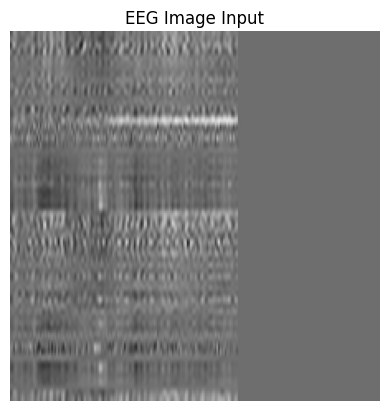

🧠 DL Class Probabilities → Control: 0.9996, Alcoholic: 0.0004
🔗 Using Combined ML + DL

📊 Final Combined Probability: 0.2300
✅ Predicted class: Control

📂 GZ Path: eeg_dataset/train_data/SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.000.gz
🖼️ Image Path: /content/eeg_2d_images/alcoholic/co2a0000364/co2a0000364_rd_000.png
🔬 ML Probability (Alcoholic): 0.4595


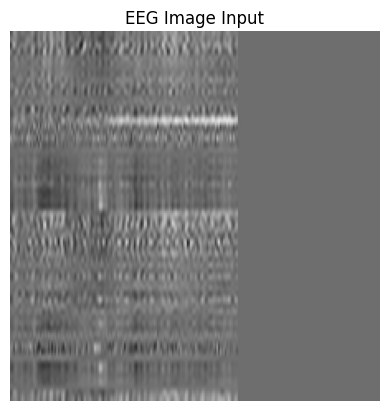

🧠 DL Class Probabilities → Control: 0.9996, Alcoholic: 0.0004
🔗 Using ML Only

📊 Final Combined Probability: 0.4595
✅ Predicted class: Control

📂 GZ Path: eeg_dataset/train_data/SMNI_CMI_TRAIN/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.000.gz
🖼️ Image Path: /content/eeg_2d_images/alcoholic/co2a0000364/co2a0000364_rd_000.png
🔬 ML Probability (Alcoholic): 0.4595


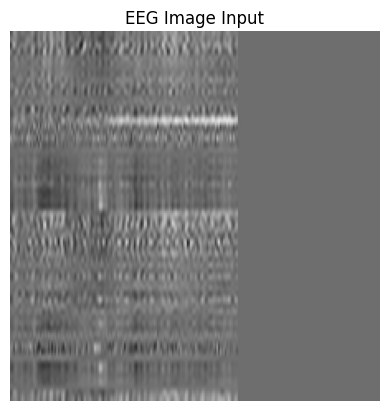

🧠 DL Class Probabilities → Control: 0.9996, Alcoholic: 0.0004
🔗 Using DL Only

📊 Final Combined Probability: 0.0004
✅ Predicted class: Control


0

In [19]:
# Combined prediction
predict_combined(gz_file, img_file, mode="combined")

# Only ML (for testing ML model only)
predict_combined(gz_file, img_file, mode="ml_only")

# Only DL (for testing DL model only)
predict_combined(gz_file, img_file, mode="dl_only")
